# Hadron Production

### November 2020

### Jack Featherstone
### Ryan Branagan

### Outline of Steps

1. Generate color charge distributions for both the proton and nucleus for each gluon degree of freedom (3)
2. Calculate the gauge field $A$ for both the proton and nucleus by solving the Poisson equation with the Fourier transform method
3. Calculate the Wilson line using the gauge field at each point and the pauli matrices
4.Calculate the adjoint representation of the Wilson line using the pauli matrices
5. Calculate $\Omega$ using the adjoint Wilson line and the proton gauge field
6. Calculate the magnitude of the momentum for each lattice point
7. Calculate the particle production using the fourier transform of $\Omega$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

from cmath import exp

from scipy.fft import ifft2, fft2

# For timing
import time

## Functions

In [ ]:
# Not used anymore
def rhoSingleColor(sigma, shape):
    return np.random.normal(scale=sigma, size=shape)

def AHat_mn(m, n, pHat_mn):
    numerator = -delta**2 * g * pHat_mn
    denominator = 2 * (np.cos(2*np.pi*m*delta/L) + np.cos(2*np.pi*n*delta/L) - 2 - (M * delta)**2 / 2)
    if denominator == 0:
        return 0
    return numerator / denominator

def xi(i):
    return i*delta

def protonFiniteSizeGaussian(x, y):
    return np.exp( - ((x - xc)**2 + (y - yc)**2) / (2*r_p**2))

## Constants

In [ ]:
# Constants
#n = 8
# Muon degrees of freedom (Nc**2 - 1)
gluonDOF = 3
# Number of lattice sites in each direction
N = 256
# Spacing between lattice sites
delta = .1
# Length of the system
L = N * delta
# Experimentally determined correction to Poisson equation
M = .5
# Radius of the proton
r_p = 2
# Laplace equation constant
g = 1
iArr, jArr = np.arange(0, N), np.arange(0, N)

# Note that we use no normalization for fft2 and ifft2
# which means that both are not scaled
# By default, only ifft2 has this option (and it's 1/n)
normalization = None

# Standard deviation of the gaussian distribution for nucleus charge density
mu = 2
sigma = mu/delta
# Standard deviation of the gaussian distribution for proton charge density
mu_p = 1
sigma_p = mu_p/delta
# Center points of our grid, used as the mean of the gaussian distributions
xc, yc = xi(N/2), xi(N/2)

# Pauli Matrices (including the identity)
sigma_0 = np.array([[1, 0], [0, 1]], dtype='complex')
sigma_x = np.array([[0, 1], [1, 0]], dtype='complex')
sigma_y = np.array([[0, -1.j], [1.j, 0]], dtype='complex')
sigma_z = np.array([[1., 0], [0, -1.]], dtype='complex')

pauli = np.array([sigma_0, sigma_x, sigma_y, sigma_z])

## Setting Up

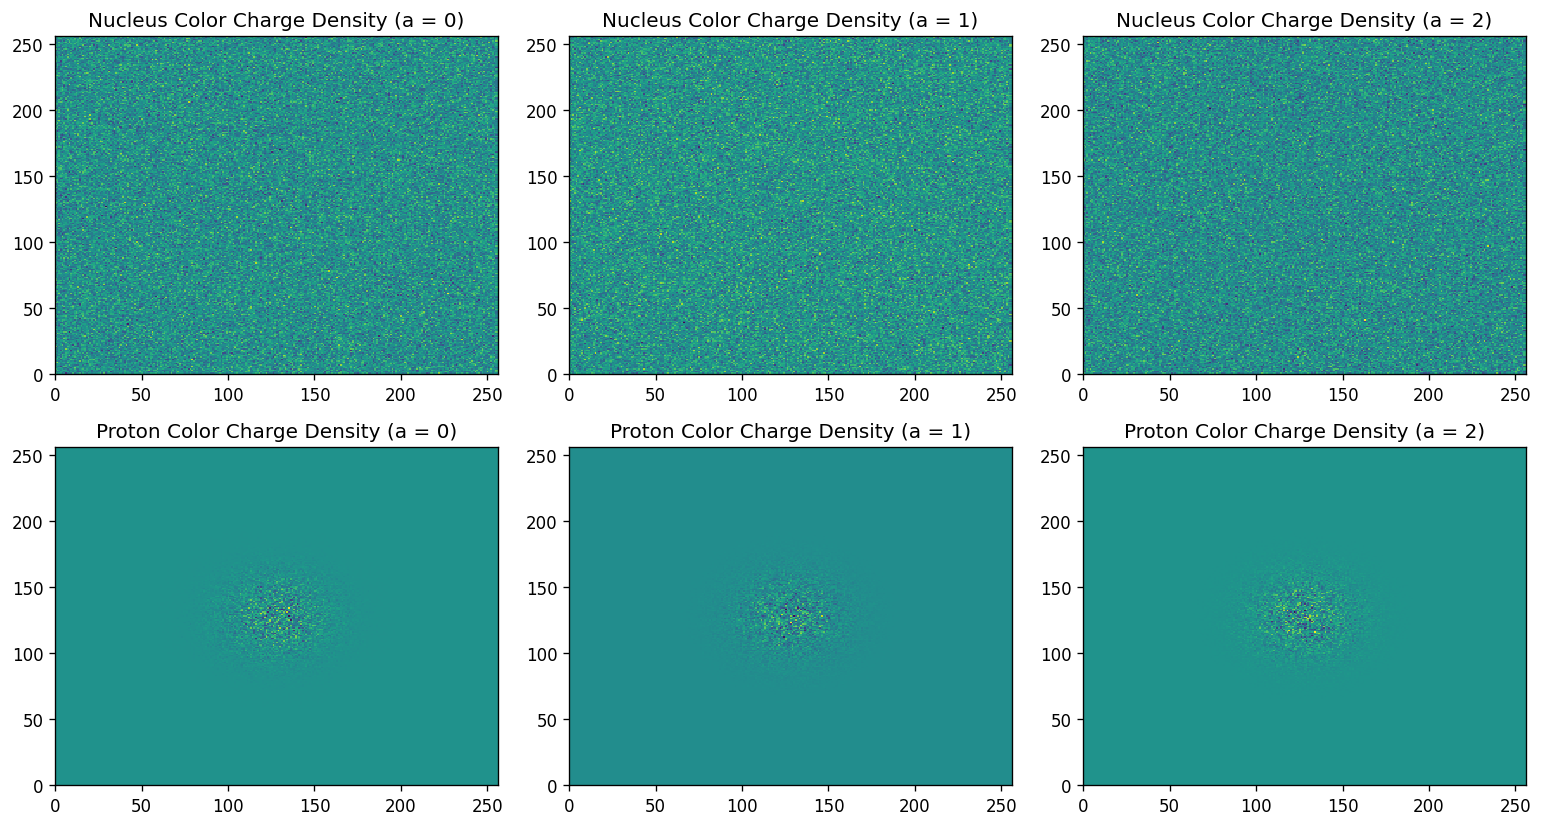

In [ ]:
def generateChargeFields(N, plot=False):
    # Color charge densities
    protonGaussianCorrection = np.array([protonFiniteSizeGaussian(xi(i), xi(jArr)) for i in iArr])

    chargeDensityArr = np.random.normal(scale=sigma, size=(gluonDOF, N, N))
    protonChargeDensityArr = np.random.normal(scale=sigma_p, size=(gluonDOF, N, N)) * protonGaussianCorrection

    # Plot everything, to make sure it looks normal
    # Keep the same color scale for both the proton and nucleus, so we need bounds
    #minColor = np.min([np.min(chargeDensityArr), np.min(protonChargeDensityArr)])
    #maxColor = np.max([np.max(chargeDensityArr), np.max(protonChargeDensityArr)])

    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(13, 7))
        for i in range(gluonDOF):
            ax[0,i].pcolor(chargeDensityArr[i])#, vmin=minColor, vmax=maxColor)
            ax[0,i].set_title(f'Nucleus Color Charge Density (a = {i})')
            ax[1,i].pcolor(protonChargeDensityArr[i])#, vmin=minColor, vmax=maxColor)
            ax[1,i].set_title(f'Proton Color Charge Density (a = {i})')

        fig.tight_layout()
        plt.show()

    return chargeDensityArr, protonChargeDensityArr
    
chargeDensityArr, protonChargeDensityArr = generateChargeFields(N, plot=True)

## Calculating Gauge Field

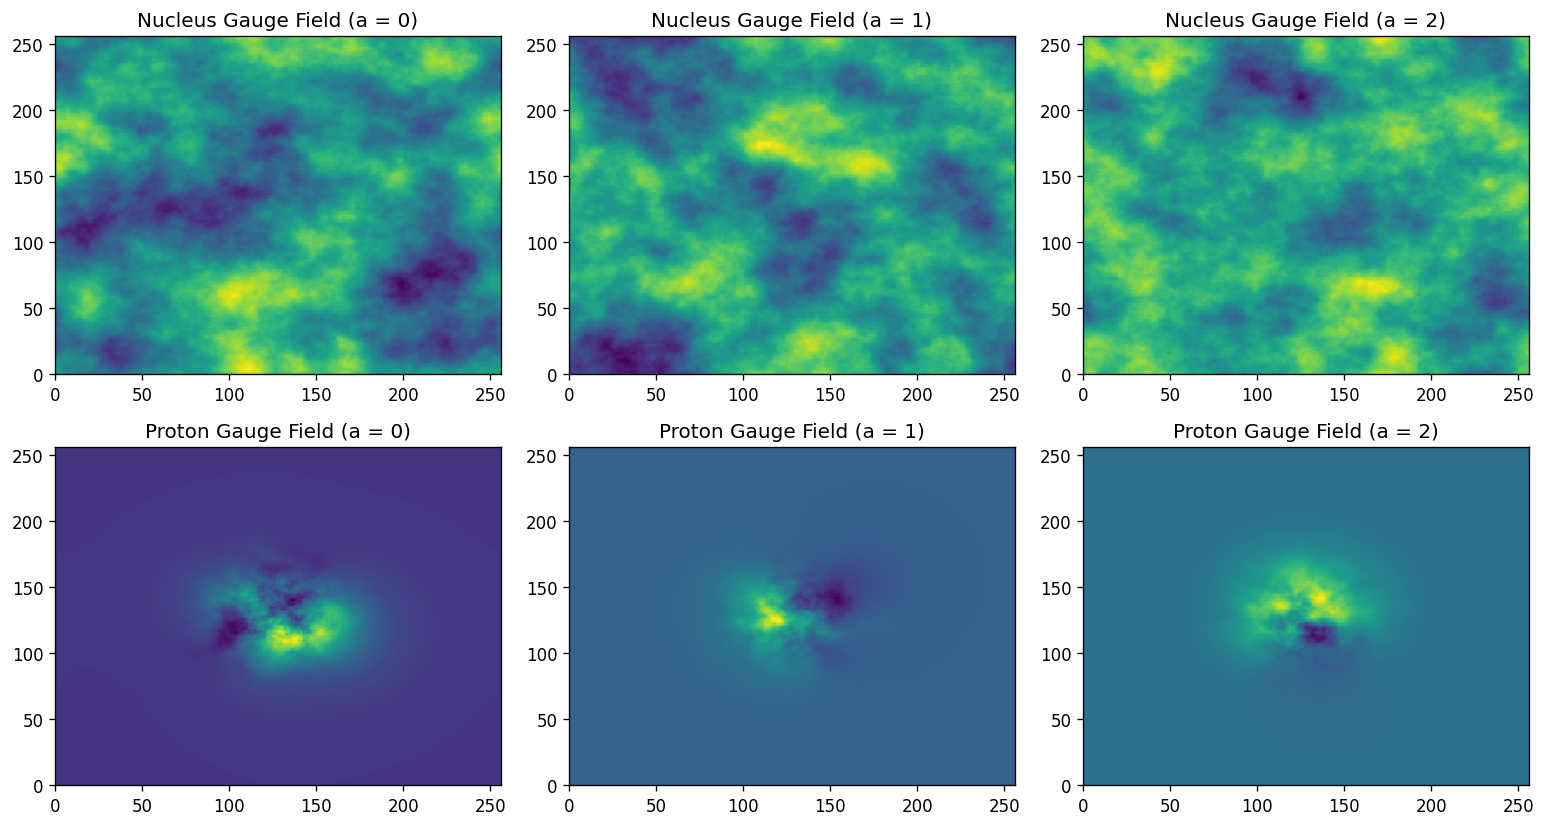

In [ ]:
def calculateGaugeField(chargeDensityArr, protonChargeDensityArr, plot=False):
    # Compute the fourier transform of the charge densities
    chargeDensityFFTArr = fft2(chargeDensityArr, axes=(-2,-1), norm=normalization)
    protonChargeDensityFFTArr = fft2(protonChargeDensityArr, axes=(-2, -1), norm=normalization)

    # Calculate the elements of A hat
    gaugeFieldFFTArr = np.zeros_like(chargeDensityArr, dtype='complex')
    protonGaugeFieldFFTArr = np.zeros_like(protonChargeDensityArr, dtype='complex')

    # Vectorize the Ahat method to make things faster
    vec_AHat_mn = np.vectorize(AHat_mn)

    for k in range(gluonDOF):
        gaugeFieldFFTArr[k] = [vec_AHat_mn(i, jArr, chargeDensityFFTArr[k,i,jArr]) for i in iArr]
        protonGaugeFieldFFTArr[k] = [vec_AHat_mn(i, jArr, protonChargeDensityFFTArr[k,i,jArr]) for i in iArr]
        
        # Slower implementation (for reference; should give exactly the same results as above)
    #     for m in range(N):
    #         for n in range(N):
    #             gaugeFieldFFTArr[k,m,n] = AHat_mn(m, n, chargeDensityArr[k,m,n])
    #             protonGaugeFieldFFTArr[k,m,n] = AHat_mn(m, n, protonChargeDensityFFTArr[k,m,n])
        
    # Now thake the inverse fourier transform
    gaugeFieldArr = np.real(ifft2(gaugeFieldFFTArr, axes=(-2, -1), norm=normalization))
    protonGaugeFieldArr = np.real(ifft2(protonGaugeFieldFFTArr, axes=(-2, -1), norm=normalization))

    if plot:
        # Plot everything, to make sure it looks normal
        # Keep the same scale for both the proton and nucleus, so we need bounds (actually nvm)
        #minColor = np.min([np.min(gaugeFieldArr), np.min(protonGaugeFieldArr)])
        #maxColor = np.max([np.max(gaugeFieldArr), np.max(protonGaugeFieldArr)])

        fig, ax = plt.subplots(2, 3, figsize=(13, 7))
        for i in range(gluonDOF):
            ax[0,i].pcolor(gaugeFieldArr[i])#, vmin=minColor, vmax=maxColor)
            ax[0,i].set_title(f'Nucleus Gauge Field (a = {i})')
            ax[1,i].pcolor(protonGaugeFieldArr[i])#, vmin=minColor, vmax=maxColor)
            ax[1,i].set_title(f'Proton Gauge Field (a = {i})')

        fig.tight_layout()
        plt.show()

    return gaugeFieldArr, protonGaugeFieldArr

gaugeFieldArr, protonGaugeFieldArr = calculateGaugeField(chargeDensityArr, protonChargeDensityArr, plot=True)

##Calculating Wilson Line

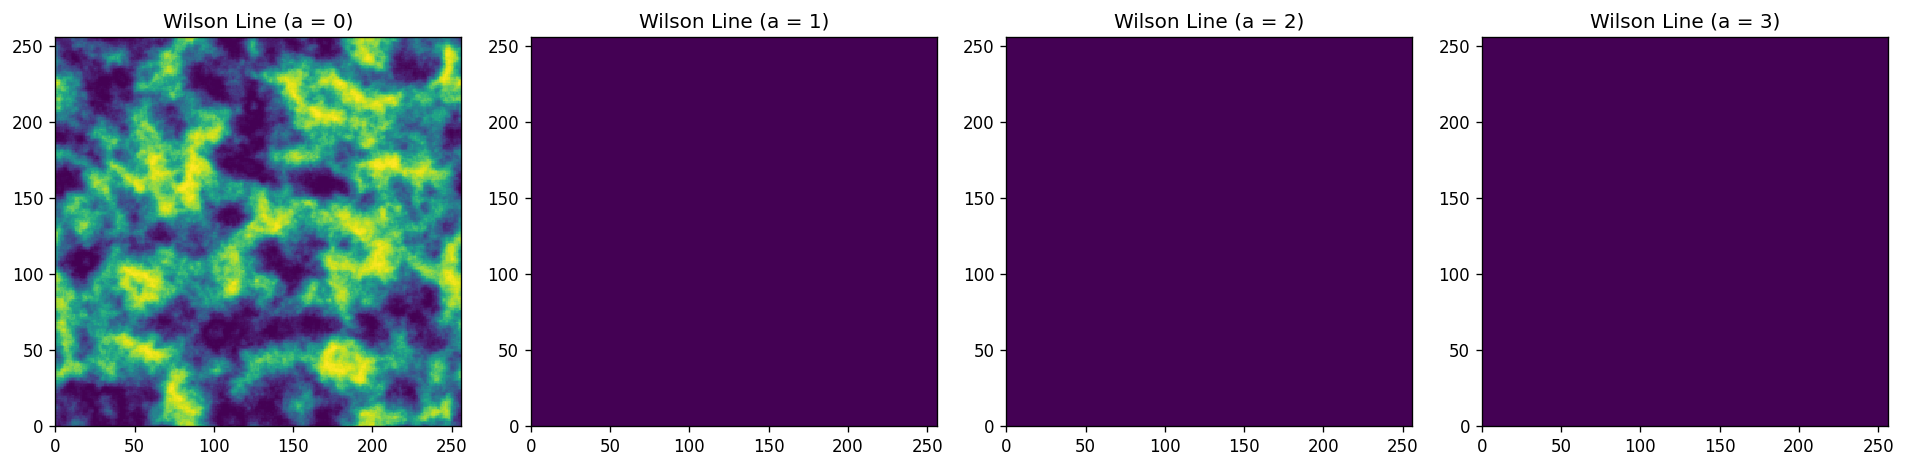

In [ ]:
def calculateWilsonLine(gaugeFieldArr, plot=False):
    wilsonLineArr = np.zeros([gluonDOF+1, N, N], dtype='complex')

    for i in range(N):
        for j in range(N):
            normA = np.sqrt(np.sum([gaugeFieldArr[k,i,j]**2 for k in range(gluonDOF)]))
            wilsonLineArr[0,i,j] = np.cos(normA)
            for k in range(gluonDOF):
                wilsonLineArr[k+1,i,j] = gaugeFieldArr[k,i,j] * 1.j * np.sin(normA) / normA

    if plot:
        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        for i in range(gluonDOF+1):
            ax[i].pcolor(np.real(wilsonLineArr[i]))
            ax[i].set_title(f'Wilson Line (a = {i})')
            
        fig.tight_layout()
        plt.show()

    return wilsonLineArr

wilsonLineArr = calculateWilsonLine(gaugeFieldArr, plot=True)

##Calculating Adjoint Wilson Line

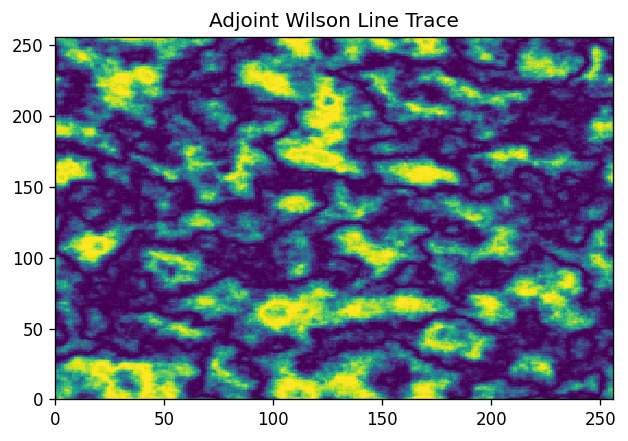

In [ ]:
def calculateAdjointWilsonLine(wilsonLineArr, plot=False):
    adjointWilsonLineArr = np.zeros([gluonDOF+1, gluonDOF+1, N, N], dtype='complex')

    # #Ryan's attempt at speed
    # Vprep = np.zeros([gluonDOF+1, N, N, 2, 2], dtype='complex')
    # VDagreus = np.zeros_like(Vprep)
    # for k in range(gluonDOF+1):
    #   for i in range(N):
    #     for j in range(N):
    #       Vprep[k,i,j] = wilsonLine[k,i,j] * pauli[k]
    #       VDagreus[k,i,j] = np.conjugate(np.transpose(Vprep[k,i,j]))

    # Vtot = np.zeros([N, N, 2, 2], dtype='complex')
    # VDtot = np.zeros_like(Vtot)
    # for k in range(gluonDOF+1):
    #   Vtot = Vtot + Vprep[k]
    #   VDtot = VDtot + VDagreus[k]

    for a in range(gluonDOF+1):
        for b in range(gluonDOF+1):
            for i in range(N):
                for j in range(N):
                    V = sum([wilsonLineArr[k,i,j]*pauli[k] for k in range(gluonDOF+1)])
                    #V = np.tensordot(wilsonLine[:,i,j], pauli, axes=1) # This is slower
                    Vdag = np.conjugate(np.transpose(V))
                    adjointWilsonLineArr[a,b,i,j] = .5 * np.trace(np.dot(np.dot(pauli[a], V), np.dot(pauli[b], Vdag)))


    if plot:
        adjointWilsonLineTrace = np.trace(adjointWilsonLineArr, axis1=0, axis2=1)

        plt.pcolor(np.abs(adjointWilsonLineTrace))
        plt.title(f'Adjoint Wilson Line Trace')

        plt.show()

    return adjointWilsonLineArr

adjointWilsonLineArr = calculateAdjointWilsonLine(wilsonLineArr, plot=True)

##Calculate $\Omega$

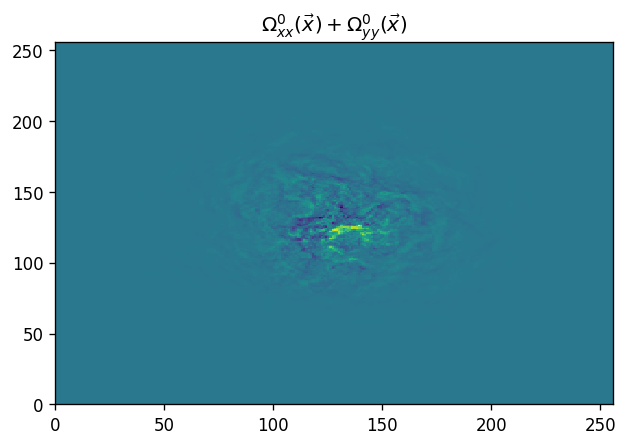

In [ ]:
def calculateOmega(protonGaugeFieldArr, adjointWilsonLineArr, plot=False):
    omegaArr = np.zeros([2, 2, gluonDOF, N, N], dtype='complex') # 2 is for two dimensions, x and y

    def x_deriv(matrix, i, j):
        return (matrix[i,(j+1)%N] - matrix[i,j-1]) / (2*delta)

    def y_deriv(matrix, i, j):
        return (matrix[(i+1)%N,j] - matrix[i-1,j]) / (2*delta)

    derivs = [x_deriv, y_deriv]

    for i in range(N):
        for j in range(N):
            for k in range(gluonDOF):
                for l in range(2):
                    for n in range(2):
                        omegaArr[l,n,k,i,j] = np.sum([derivs[l](protonGaugeFieldArr[m], i, j) * derivs[n](adjointWilsonLineArr[k+1, m+1], i, j) for m in range(gluonDOF)])

    if plot:        
        plt.pcolor(np.real(omegaArr[0, 0, 0] + omegaArr[1, 1, 0]))
        plt.title(r'$\Omega_{xx}^0(\vec x) + \Omega_{yy}^0(\vec x)$')
        plt.show()

    return omegaArr

omegaArr = calculateOmega(protonGaugeFieldArr, adjointWilsonLineArr, plot=True)

##Perform $\Omega$ FFT

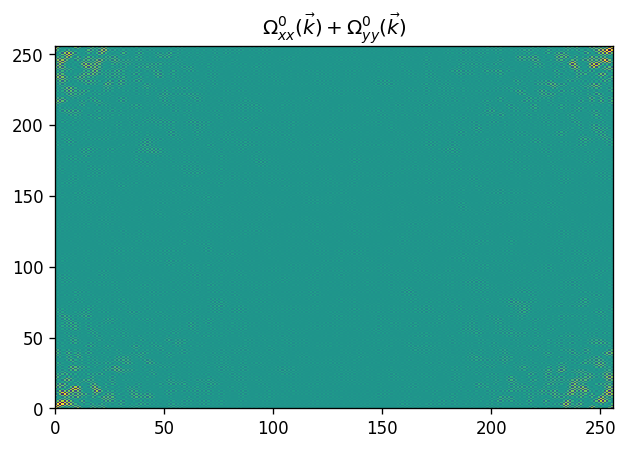

In [ ]:
def calculateOmegaFFT(omegaArr, plot=False):
    omegaFFTArr = fft2(omegaArr, axes=(-2, -1), norm=normalization)

    if plot:
        plt.pcolor(np.real(omegaFFTArr[0, 0, 0] + omegaFFTArr[1, 1, 0]))
        plt.title(r'$\Omega_{xx}^0(\vec k) + \Omega_{yy}^0(\vec k)$')
        plt.show()

    return omegaFFTArr

omegaFFTArr = calculateOmegaFFT(omegaArr, plot=True)

##Calculating Particle Production

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


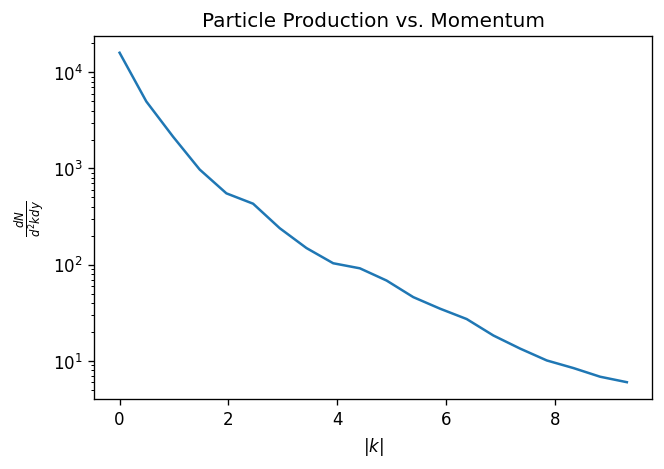

In [ ]:
def calculateParticlesProduced(omegaFFTArr, plot=False):
    momentaMagSquaredArr = np.zeros([N, N])

    for i in range(N):
        for j in range(N):
            momentaMagSquaredArr[i,j] = 4 / delta**2 * (np.sin((2*np.pi*i/L)*delta/2)**2 + np.sin((2*np.pi*j/L)*delta/2)**2)
            
    particleProductionArr = np.zeros([N, N])

    # # Levi-Cevita symbol
    # def lc(i, j):
    #     return (i + j)%2 * (j - i)

    #Matrix Representation
    LCS = np.array([[0,1],[-1,0]])

    # # Delta function
    # def df(i, j):
    #     return i == j

    #Matrix Representation
    KDF = np.array([[1,0],[0,1]])

    for y in range(N):
        for x in range(N):
            
            for i in range(2):
                for j in range(2):
                    for l in range(2):
                        for m in range(2):
                    
                            for a in range(gluonDOF):
                                particleProductionArr[y,x] += 2/(2*np.pi)**3 / momentaMagSquaredArr[y,x] * (KDF[i,j]*KDF[l,m] + LCS[i,j]*LCS[l,m]) * omegaFFTArr[i,j,a,y,x] * np.conj(omegaFFTArr[l,m,a,y,x])

    particlesArr = np.reshape(particleProductionArr, [N*N])
    momentaArr = np.reshape(np.sqrt(momentaMagSquaredArr), [N*N])

    # Now bin stuff
    binSize = 4*np.pi/L
    kMax = 1/delta

    numBins = int(kMax/binSize)

    averageParticlesArr = np.zeros(numBins)
    averageMomentaArr = [i*binSize for i in range(numBins)]

    # Note the use of element-wise (or bitwise) and, "&"
    for i in range(numBins):
        averageParticlesArr[i] = np.mean(particlesArr[(momentaArr < binSize*(i+1)) & (momentaArr > binSize*i)])

    if plot:
        plt.plot(averageMomentaArr, averageParticlesArr)
        plt.yscale('log')
        plt.xlabel(r'$|k|$')
        plt.ylabel(r'$\frac{d N}{d^2 k d y}$')
        plt.title('Particle Production vs. Momentum')
        plt.show()
        #plt.plot(momentaArr, particlesArr, 'o')

    return averageMomentaArr, averageParticlesArr

averageMomentaArr, averageParticlesArr = calculateParticlesProduced(omegaFFTArr, plot=True)

#Calculating Average

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in cdouble_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


 Completed batch 0 in 91.42192800000001s
 Completed batch 10 in 997.768967s
 Completed batch 20 in 1907.9971330000003s
 Completed batch 30 in 2813.744220000001s
 Completed batch 40 in 3714.2185470000018s
 Completed batch 50 in 4623.991702000004s
 Completed batch 60 in 5535.150418000003s
 Completed batch 70 in 6440.004359000005s
 Completed batch 80 in 7330.354410000006s
 Completed batch 90 in 8215.500548000005s


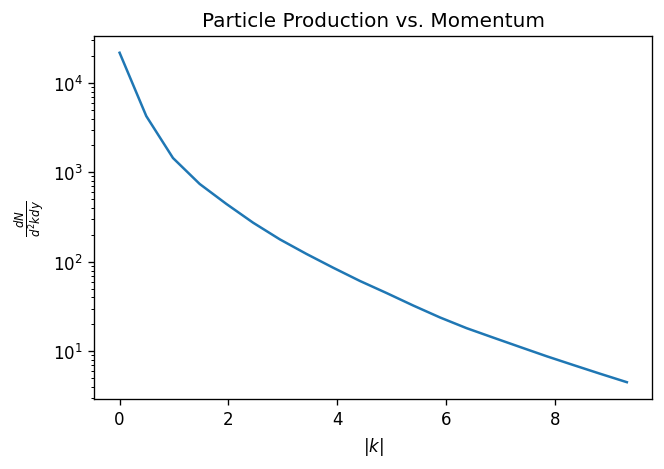

In [ ]:
batches = 100

# Set up our return arrays
binSize = 4*np.pi/L
kMax = 1/delta

numBins = int(kMax/binSize)

averageParticlesArr = np.zeros(numBins)
averageMomentaArr = np.zeros(numBins)

totalTime = 0.
printSkip = 10

for bat in range(batches):
    beginTime = time.clock()

    # Calculate all of the quantities, just like above, but don't plot now
    chargeDensityArr, protonChargeDensityArr = generateChargeFields(N)
    gaugeFieldArr, protonGaugeFieldArr = calculateGaugeField(chargeDensityArr, protonChargeDensityArr)
    wilsonLineArr = calculateWilsonLine(gaugeFieldArr)
    adjointWilsonLineArr = calculateAdjointWilsonLine(wilsonLineArr)
    omegaArr = calculateOmega(protonGaugeFieldArr, adjointWilsonLineArr)
    omegaFFTArr = calculateOmegaFFT(omegaArr)
    batMomentaArr, batParticlesArr = calculateParticlesProduced(omegaFFTArr)
    
    # Add it to the running total
    averageParticlesArr += batParticlesArr
    averageMomentaArr += batMomentaArr

    # Debugging and timing
    totalTime += time.clock() - beginTime
    if bat % printSkip == 0:
        print(f'\r Completed batch {bat} in {totalTime}s')

averageParticlesArr /= batches
averageMomentaArr /= batches

plt.plot(averageMomentaArr, averageParticlesArr)
plt.yscale('log')
plt.xlabel(r'$|k|$')
plt.ylabel(r'$\frac{d N}{d^2 k d y}$')
plt.title('Particle Production vs. Momentum')
plt.show()